In [86]:
import yfinance as yf
import pandas as pd
import numpy as np


# Download ~60 days M15 = 5000+ bars
ticker = 'EURUSD=X'
df = yf.download(ticker, period='60d', interval='15m', auto_adjust=False)
df = df[['Open', 'High', 'Low', 'Close']].dropna()
print(f"Loaded {len(df):,} M15 bars: {df.index[0].date()} to {df.index[-1].date()}")


[*********************100%***********************]  1 of 1 completed

Loaded 5,585 M15 bars: 2025-09-15 to 2025-12-05


In [89]:
import talib
import numpy as np
import pandas as pd

# Fix MultiIndex columns - extract just the price data
df.columns = [col[0] for col in df.columns]  # ['Open', 'High', 'Low', 'Close']

# Now convert to proper 1D arrays
close = df['C'].values
high = df['H'].values
low = df['L'].values

In [90]:
# TA-Lib will now work
macd, signal, hist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd
df['RSI'] = talib.RSI(close, timeperiod=14)
df['ATR'] = talib.ATR(high, low, close, timeperiod=14)

df = df.dropna()
print(f"After indicators: {len(df):,} bars")


After indicators: 5,552 bars


In [91]:
def generate_labels(df, mult=0.5, RR=2):

    # Add label column directly to the dataframe
    df['label'] = 0  # Initialize with neutral
    
    for i in range(1, len(df)):  # Start after indicator warmup
        # ENTRY at OPEN of current bar i
        entry_price = df['O'].iloc[i]
        
        # FEATURES from PREVIOUS closed bar (i-1)
        prev_macd = df['MACD'].iloc[i-1]
        prev_rsi = df['RSI'].iloc[i-1]
        prev_atr = df['ATR'].iloc[i-1]
        
        # Skip if any feature NaN
        if pd.isna(prev_macd) or pd.isna(prev_rsi) or pd.isna(prev_atr):
            continue
            
        sl_distance = mult * prev_atr
        tp_distance = RR * mult * prev_atr
        
        # Simulate forward from CURRENT bar i+1 onwards
        future_bars = df.iloc[i+1:i+51]  # Max 50 bars lookahead
        if len(future_bars) < 5:  # Need minimum bars
            continue
            
        highs = future_bars['H']
        lows = future_bars['L']
        
        # Check BUY: TP hits before SL
        tp_buy_level = entry_price + tp_distance
        sl_buy_level = entry_price - sl_distance
        
        buy_tp_idx = highs[highs >= tp_buy_level].index.min() if (highs >= tp_buy_level).any() else None
        buy_sl_idx = lows[lows <= sl_buy_level].index.min() if (lows <= sl_buy_level).any() else None
        
        buy_win = False
        if buy_tp_idx is not None and buy_sl_idx is not None:
            buy_win = buy_tp_idx < buy_sl_idx  # TP first
        elif buy_tp_idx is not None:
            buy_win = True  # TP hit, no SL
        
        # Check SELL: TP hits before SL  
        tp_sell_level = entry_price - tp_distance
        sl_sell_level = entry_price + sl_distance
        
        sell_tp_idx = lows[lows <= tp_sell_level].index.min() if (lows <= tp_sell_level).any() else None
        sell_sl_idx = highs[highs >= sl_sell_level].index.min() if (highs >= sl_sell_level).any() else None
        
        sell_win = False
        if sell_tp_idx is not None and sell_sl_idx is not None:
            sell_win = sell_tp_idx < sell_sl_idx  # TP first
        elif sell_tp_idx is not None:
            sell_win = True  # TP hit, no SL
        
        # Direct assignment to dataframe column
        if buy_win and sell_win:
            df.loc[df.index[i], 'label'] = 0   # Both win: neutral
        elif buy_win:
            df.loc[df.index[i], 'label'] = 1   # Buy only
        elif sell_win:
            df.loc[df.index[i], 'label'] = -1  # Sell only
        # else: remains 0 (neutral)
    
    return df

# Usage - now returns the full dataframe with labels
mult = 2
RR = 2
df_with_labels = generate_labels(df, mult, RR)

print("Sample data:")
print(df_with_labels[['MACD', 'RSI', 'ATR', 'label']].head(10))
print(df_with_labels[['MACD', 'RSI', 'ATR', 'label']].tail(10))
print("\nLabel distribution:")
print(df_with_labels['label'].value_counts())


C:\Users\acer\AppData\Local\Temp\ipykernel_29020\4010573603.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = 0  # Initialize with neutral


Sample data:
                               MACD        RSI       ATR  label
Datetime                                                       
2025-09-16 07:15:00+00:00  0.000755  75.275793  0.000463      0
2025-09-16 07:30:00+00:00  0.000758  67.365033  0.000509      1
2025-09-16 07:45:00+00:00  0.000762  68.551749  0.000533      1
2025-09-16 08:00:00+00:00  0.000779  70.835003  0.000544      1
2025-09-16 08:15:00+00:00  0.000784  70.835003  0.000575      1
2025-09-16 08:30:00+00:00  0.000734  60.625343  0.000584      1
2025-09-16 08:45:00+00:00  0.000709  63.461127  0.000572      1
2025-09-16 09:00:00+00:00  0.000759  71.267947  0.000621      1
2025-09-16 09:15:00+00:00  0.000811  73.042335  0.000616      0
2025-09-16 09:30:00+00:00  0.000910  77.529496  0.000632      0
                               MACD        RSI       ATR  label
Datetime                                                       
2025-12-05 20:00:00+00:00 -0.000144  46.086769  0.000438      0
2025-12-05 20:15:00+00:00 -

In [92]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# Split 20% test set (final 20% chronological)
test_size = int(len(df_with_labels) * 0.2)
train_val_df = df_with_labels.iloc[:-test_size].copy()
test_df = df_with_labels.iloc[-test_size:].copy()

print(f"Train+Val: {len(train_val_df):,} bars, Test: {len(test_df):,} bars")

# === CLEAN DATA - Direct DataFrame column access ===
print("Cleaning data - removing NaN in features or labels...")

feature_cols = ['MACD', 'RSI']
label_col = 'label'

# Train+Val cleaning - Direct column access (no Series needed)
train_val_clean = (
    train_val_df[feature_cols].notna().all(axis=1) & 
    train_val_df[label_col].notna()
)
X = train_val_df.loc[train_val_clean, feature_cols].copy()
y = train_val_df.loc[X.index, label_col].copy()

print(f"Clean Train+Val - X: {X.shape}, y: {y.shape}")
print(f"y value counts:\n{y.value_counts().sort_index()}")

# Test cleaning - Direct column access
test_clean = (
    test_df[feature_cols].notna().all(axis=1) & 
    test_df[label_col].notna()
)
X_test_clean = test_df.loc[test_clean, feature_cols].copy()
y_test_clean = test_df.loc[X_test_clean.index, label_col].copy()

print(f"Clean Test - X_test: {X_test_clean.shape}, y_test: {y_test_clean.shape}")
print(f"y_test value counts:\n{y_test_clean.value_counts().sort_index()}")


Train+Val: 4,442 bars, Test: 1,110 bars
Cleaning data - removing NaN in features or labels...
Clean Train+Val - X: (4442, 2), y: (4442,)
y value counts:
label
-1    1308
 0    1847
 1    1287
Name: count, dtype: int64
Clean Test - X_test: (1110, 2), y_test: (1110,)
y_test value counts:
label
-1    243
 0    520
 1    347
Name: count, dtype: int64


In [93]:

# Fixed window CV
tscv = TimeSeriesSplit(
    n_splits=20,          
    max_train_size=500,   
    test_size=200         
)


# Initialize totals
total_train_holds, total_train_buys, total_train_sells = 0, 0, 0
total_val_holds, total_val_buys, total_val_sells = 0, 0, 0

scores = []
fold_num = 0
for train_idx, val_idx in tscv.split(X):
    fold_num += 1
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Count classes
    train_holds = (y_train == 0).sum()
    train_buys = (y_train == 1).sum()
    train_sells = (y_train == -1).sum()
    val_holds = (y_val == 0).sum()
    val_buys = (y_val == 1).sum()
    val_sells = (y_val == -1).sum()
    
    # Update totals
    total_train_holds += train_holds
    total_train_buys += train_buys
    total_train_sells += train_sells
    total_val_holds += val_holds
    total_val_buys += val_buys
    total_val_sells += val_sells
    
    print(f"Fold {fold_num}:")
    print(f"  Training set: {train_idx[0]}-{train_idx[-1]} ({len(train_idx)} samples)")
    print(f"    Holds: {train_holds}, Buys: {train_buys}, Sells: {train_sells}")
    print(f"  Validation set: {val_idx[0]}-{val_idx[-1]} ({len(val_idx)} samples)")
    print(f"    Holds: {val_holds}, Buys: {val_buys}, Sells: {val_sells}")
    print()
    
    model = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_leaf=20, 
                                  class_weight={-1:1, 0:1, 1:1})
    model.fit(X_train, y_train)
    score = model.score(X_val, y_val)
    scores.append(score)

# Print totals
print("Total counts across all folds:")
print(f"  Training - Holds: {total_train_holds}, Buys: {total_train_buys}, Sells: {total_train_sells}")
print(f"  Validation - Holds: {total_val_holds}, Buys: {total_val_buys}, Sells: {total_val_sells}")

cv_score = np.mean(scores)
print(f"CV Accuracy: {cv_score:.3f} (+/- {np.std(scores)*2:.3f})")


Fold 1:
  Training set: 0-441 (442 samples)
    Holds: 162, Buys: 141, Sells: 139
  Validation set: 442-641 (200 samples)
    Holds: 83, Buys: 29, Sells: 88

Fold 2:
  Training set: 142-641 (500 samples)
    Holds: 201, Buys: 111, Sells: 188
  Validation set: 642-841 (200 samples)
    Holds: 84, Buys: 69, Sells: 47

Fold 3:
  Training set: 342-841 (500 samples)
    Holds: 199, Buys: 166, Sells: 135
  Validation set: 842-1041 (200 samples)
    Holds: 84, Buys: 82, Sells: 34

Fold 4:
  Training set: 542-1041 (500 samples)
    Holds: 218, Buys: 156, Sells: 126
  Validation set: 1042-1241 (200 samples)
    Holds: 75, Buys: 84, Sells: 41

Fold 5:
  Training set: 742-1241 (500 samples)
    Holds: 196, Buys: 219, Sells: 85
  Validation set: 1242-1441 (200 samples)
    Holds: 52, Buys: 35, Sells: 113

Fold 6:
  Training set: 942-1441 (500 samples)
    Holds: 155, Buys: 174, Sells: 171
  Validation set: 1442-1641 (200 samples)
    Holds: 73, Buys: 33, Sells: 94

Fold 7:
  Training set: 1142-164

In [94]:
# === FINAL TEST EVALUATION ===
print(f"\n{'='*50}")
print(f"FINAL TEST:")
print(f"{'='*50}")

# Train final model on ALL clean train+val data
final_model = DecisionTreeClassifier(random_state=42, max_depth=3, min_samples_leaf=20, 
                                    class_weight={-1:1, 0:1, 1:1})
final_model.fit(X, y)  # Already clean!

# Test predictions
y_pred = final_model.predict(X_test_clean)
print(classification_report(y_test_clean, y_pred, target_names=['Hold', 'Sell', 'Buy'], zero_division=0))
print(f"Test Accuracy: {final_model.score(X_test_clean, y_test_clean):.3f}")



FINAL TEST:
              precision    recall  f1-score   support

        Hold       0.00      0.00      0.00       243
        Sell       0.47      0.60      0.52       520
         Buy       0.32      0.41      0.36       347

    accuracy                           0.41      1110
   macro avg       0.26      0.34      0.30      1110
weighted avg       0.32      0.41      0.36      1110

Test Accuracy: 0.409


In [96]:
def verify_alignment(X_test, y_test, y_pred):
    print("🔍 ALIGNMENT CHECK:")
    print(f"  Shapes: X={X_test.shape}, y={y_test.shape}, pred={y_pred.shape}")
    print(f"  Indices match: {X_test.index.equals(y_test.index)}")
    print(f"  Sample: pred[0]={y_pred[0]}, actual[0]={y_test.values[0]}, date={X_test.index[0]}")
    assert len(X_test) == len(y_test) == len(y_pred), "ALIGNMENT FAILED!"
    print("✅ READY FOR EQUITY CURVE")

# Use it:
verify_alignment(X_test_clean, y_test_clean, y_pred)

🔍 ALIGNMENT CHECK:
  Shapes: X=(1110, 2), y=(1110,), pred=(1110,)
  Indices match: True
  Sample: pred[0]=0, actual[0]=1, date=2025-11-20 06:00:00+00:00
✅ READY FOR EQUITY CURVE


In [97]:
print(f"\n{'='*60}")
print(f"SIMPLE EQUITY CURVE")
print(f"{'='*60}")

risk_per_trade = 100  # 1% of 100k capital

# Generate predictions
y_pred = final_model.predict(X_test_clean)
y_test_np = y_test_clean.values  # pandas Series -> numpy array

# Simulate balance curve - ONLY on signal predictions
balance = 100000  # Starting capital
equity_curve = [balance]
dates = [X_test_clean.index[0]] if len(X_test_clean) > 0 else []
wins=0
total_signal_trades=0

for i in range(len(y_test_np)):
    pred = y_pred[i]
    actual = y_test_np[i]

    # Only trade on Buy/Sell signals
    if pred == 1 or pred == -1:
        total_signal_trades += 1
        if pred == actual:  # Win
            wins += 1
            balance += RR * risk_per_trade
        else:  # Loss
            balance -= risk_per_trade

    # Append current balance and date regardless of trade or hold
    equity_curve.append(balance)
    dates.append(X_test_clean.index[i])


# Create results DataFrame
equity_df = pd.DataFrame({'date': dates, 'balance': equity_curve})
equity_df['return_pct'] = equity_df['balance'].pct_change() * 100

# Key metrics (signal-only trades)
win_rate = wins / total_signal_trades if total_signal_trades > 0 else 0

total_return = (balance / 100000 - 1) * 100
max_dd = ((equity_df['balance'].cummax() - equity_df['balance']) / equity_df['balance'].cummax() * 100).max()

print(f"Total Signal Trades: {total_signal_trades}")
print(f"Wins: {wins} ({win_rate:.1%} win rate)")
print(f"Final Balance: ${balance:,.0f}")
print(f"Total Return: {total_return:.1f}%")
print(f"Max Drawdown: -{max_dd:.1f}%")
print(f"Profit Factor: {RR * win_rate / (1 - win_rate):.2f}" if win_rate < 1 else "Infinite")




SIMPLE EQUITY CURVE
Total Signal Trades: 445
Wins: 143 (32.1% win rate)
Final Balance: $98,400
Total Return: -1.6%
Max Drawdown: -9.5%
Profit Factor: 0.95


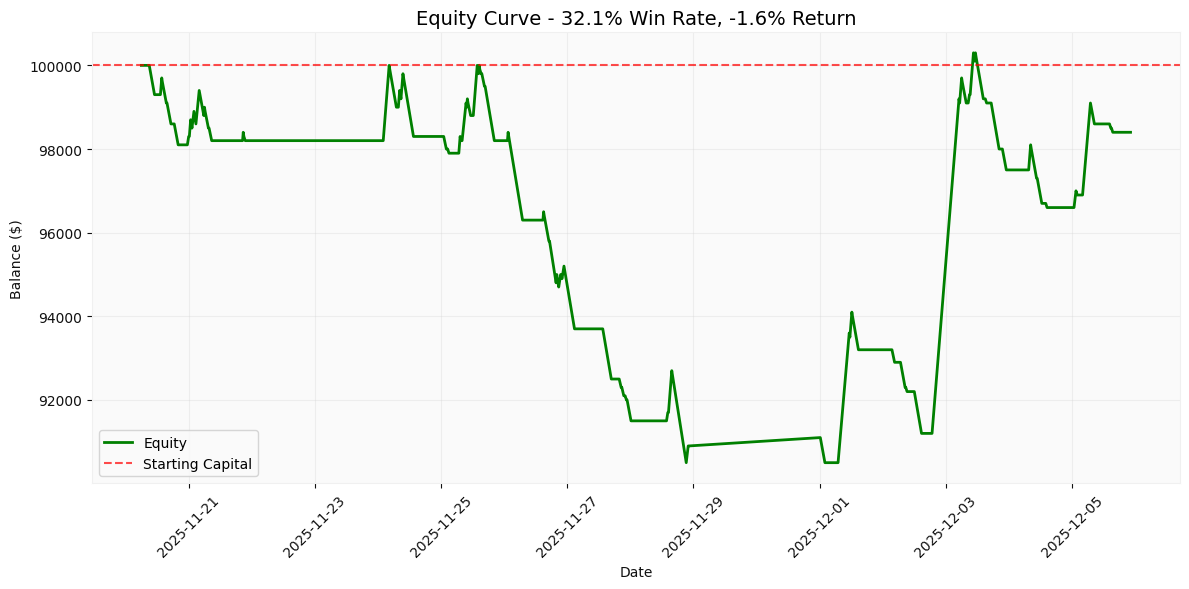

In [98]:
# Plot equity curve
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(equity_df['date'], equity_df['balance'], linewidth=2, color='green', label='Equity')
plt.axhline(y=100000, color='red', linestyle='--', alpha=0.7, label='Starting Capital')
plt.title(f'Equity Curve - {win_rate:.1%} Win Rate, {total_return:.1f}% Return', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Balance ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [99]:
print("Model classes:", final_model.classes_)
# Expected: [-1  0  1]
print("Correct class_names:", ['Sell', 'Hold', 'Buy'])

Model classes: [-1  0  1]
Correct class_names: ['Sell', 'Hold', 'Buy']


In [ ]:
# Feature importance (PERFECT ✅)
print("Feature Importance:")
for name, score in zip(feature_cols, final_model.feature_importances_):
    print(f"{name}: {score:.3f}")

Feature Importance:
MACD: 0.765
RSI: 0.235


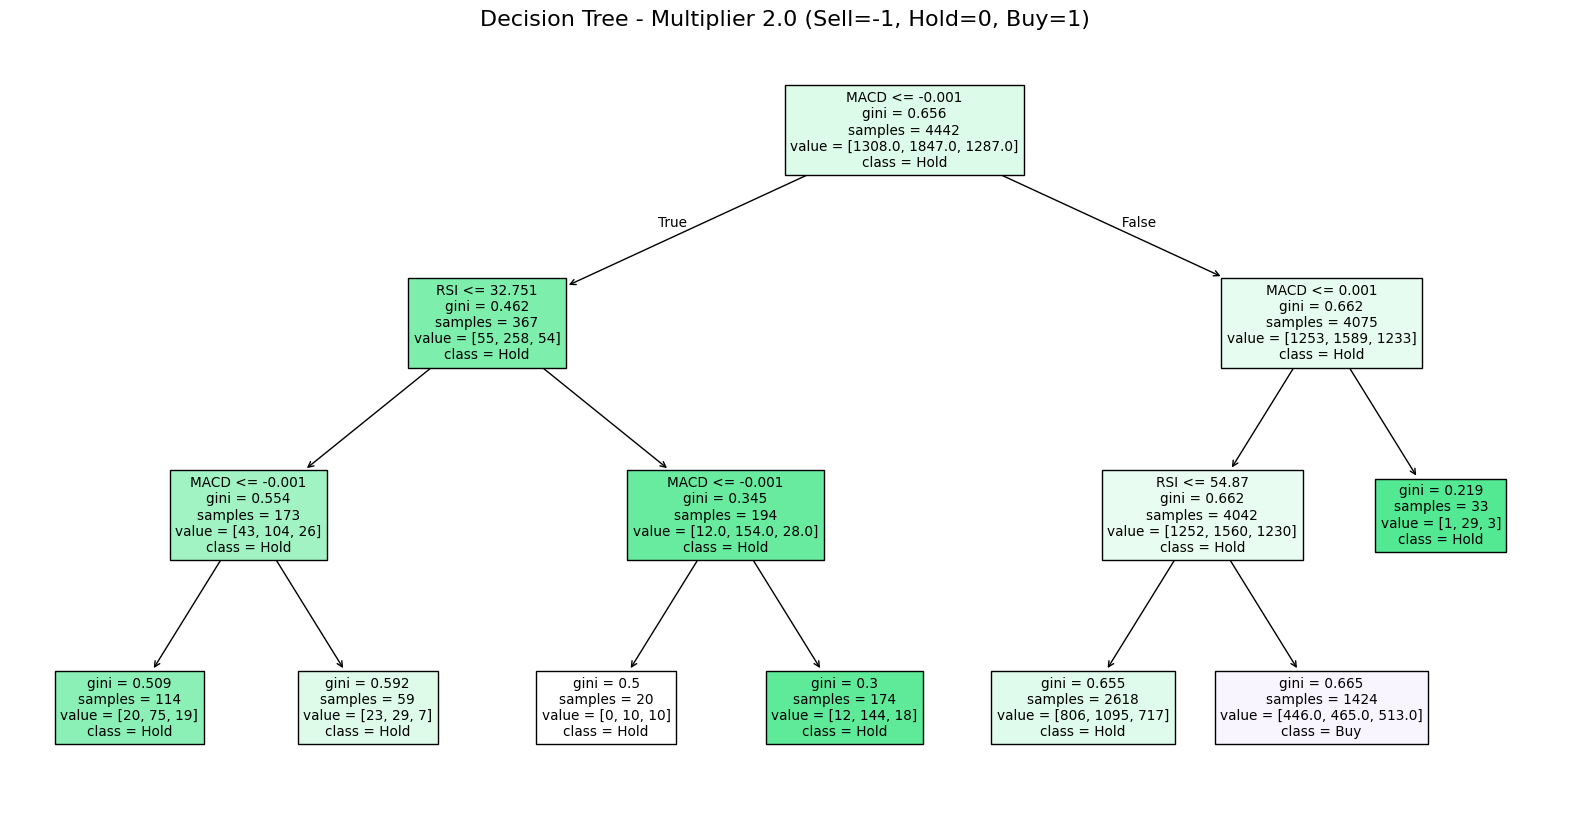

In [100]:
# Tree visualization (CORRECTED)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(final_model, 
          feature_names=feature_cols, 
          class_names=['Sell', 'Hold', 'Buy'],  # ✅ Matches [-1, 0, 1] order
          max_depth=3, 
          filled=True)
plt.title("Decision Tree - Multiplier 2.0 (Sell=-1, Hold=0, Buy=1)", fontsize=16)
plt.show()


In [101]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas as pd

# --- make sure df_with_labels has DatetimeIndex and OHLC names ---
plot_df = df_with_labels.copy()

plot_df = plot_df.rename(columns={
    'O': 'Open',
    'H': 'High',
    'L': 'Low',
    'C': 'Close'
})

# Ensure index is datetime
plot_df.index = pd.to_datetime(plot_df.index)
print(plot_df.index)


DatetimeIndex(['2025-09-16 07:15:00+00:00', '2025-09-16 07:30:00+00:00',
               '2025-09-16 07:45:00+00:00', '2025-09-16 08:00:00+00:00',
               '2025-09-16 08:15:00+00:00', '2025-09-16 08:30:00+00:00',
               '2025-09-16 08:45:00+00:00', '2025-09-16 09:00:00+00:00',
               '2025-09-16 09:15:00+00:00', '2025-09-16 09:30:00+00:00',
               ...
               '2025-12-05 20:00:00+00:00', '2025-12-05 20:15:00+00:00',
               '2025-12-05 20:30:00+00:00', '2025-12-05 20:45:00+00:00',
               '2025-12-05 21:00:00+00:00', '2025-12-05 21:15:00+00:00',
               '2025-12-05 21:30:00+00:00', '2025-12-05 21:45:00+00:00',
               '2025-12-05 22:00:00+00:00', '2025-12-05 22:15:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=5552, freq=None)


c:\Users\acer\py\tree_classifier_trader_macd_rsi\venv\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+
C:\Users\acer\AppData\Local\Temp\ipykernel_29020\1961647327.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


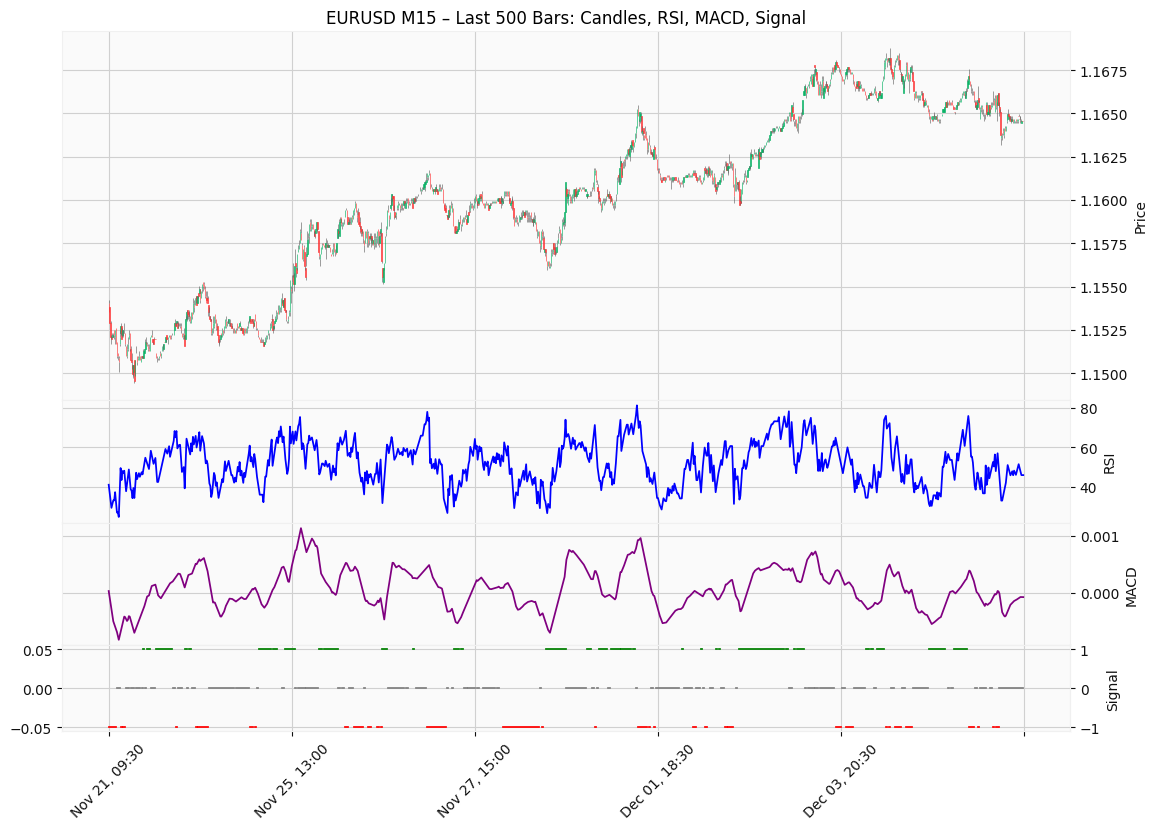

In [102]:
import mplfinance as mpf
import matplotlib.pyplot as plt

# ==== PREPARE DATA FOR PLOTTING (LAST 500 BARS) ====
last_n = 1000
plot_df = df_with_labels.copy().iloc[-last_n:]  # last 500 rows

# Rename OHLC to what mplfinance expects
plot_df = plot_df.rename(columns={
    'O': 'Open',
    'H': 'High',
    'L': 'Low',
    'C': 'Close'
})

# Ensure index is DatetimeIndex and sorted
plot_df = plot_df.sort_index()

# Build signal strip series: Buy=1 (green), Sell=-1 (red), Hold=0 (grey)
labels = plot_df['label'].astype(int)

signal_buy  = labels.where(labels ==  1)
signal_sell = labels.where(labels == -1)
signal_hold = labels.where(labels ==  0)

# ==== BUILD ADDITIONAL PLOTS (PANELS) ====
apds = [
    mpf.make_addplot(plot_df['RSI'],
                     panel=1,
                     color='blue',
                     ylabel='RSI'),

    mpf.make_addplot(plot_df['MACD'],
                     panel=2,
                     color='purple',
                     ylabel='MACD'),

    mpf.make_addplot(signal_buy,
                     panel=3,
                     color='green',
                     ylabel='Signal'),
    mpf.make_addplot(signal_sell,
                     panel=3,
                     color='red'),
    mpf.make_addplot(signal_hold,
                     panel=3,
                     color='grey'),
]

# ==== PLOT CANDLES + INDICATORS + SIGNAL STRIP ====
fig, axes = mpf.plot(
    plot_df,
    type='candle',
    addplot=apds,
    style='yahoo',
    xrotation=45,
    show_nontrading=False,
    returnfig=True,
    figsize=(14, 10),
    panel_ratios=(3, 1, 1, 0.7),
)

axes[0].set_title('EURUSD M15 – Last 500 Bars: Candles, RSI, MACD, Signal')
plt.tight_layout()
plt.show()
